Extension from [synthetic_photometry.ipynb](synthetic_photometry.ipynb)

In [1]:
import numpy as np

import collections
from pathlib import Path

from astropy.io import fits, votable
from astropy import table
from astropy.utils.data import get_readable_fileobj
from astropy import units as u
from astropy.coordinates import Distance

from specutils import Spectrum1D, SpectralRegion, manipulation, SpectralAxis

from tqdm.autonotebook import tqdm
from multiprocess import Pool

%matplotlib inline
from matplotlib import pyplot as plt

/var/folders/01/gtn_tmm5757drm_2_lrv5q780001l4/T/ipykernel_3832/4068227911.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
datadir = Path('fullgrid')
fitspaths = list(datadir.glob('lte*.fits'))
wavepaths = list(datadir.glob('WAVE*.fits'))
assert len(wavepaths)==1

In [29]:
phoenix_model_waves = fits.getdata(wavepaths[0], 0) * u.angstrom

# Do photometry on the models for the SDSS filters

load the magic band from Ani on Slack

In [26]:
CaHK_filter_str = """
3.850000000000000000e+03 0.000000000000000000e+00
3.850500000000000000e+03 0.000000000000000000e+00
3.851000000000000000e+03 0.000000000000000000e+00
3.851500000000000000e+03 0.000000000000000000e+00
3.852000000000000000e+03 0.000000000000000000e+00
3.852500000000000000e+03 0.000000000000000000e+00
3.853000000000000000e+03 0.000000000000000000e+00
3.853500000000000000e+03 0.000000000000000000e+00
3.854000000000000000e+03 0.000000000000000000e+00
3.854500000000000000e+03 0.000000000000000000e+00
3.855000000000000000e+03 0.000000000000000000e+00
3.855500000000000000e+03 0.000000000000000000e+00
3.856000000000000000e+03 0.000000000000000000e+00
3.856500000000000000e+03 0.000000000000000000e+00
3.857000000000000000e+03 0.000000000000000000e+00
3.857500000000000000e+03 0.000000000000000000e+00
3.858000000000000000e+03 0.000000000000000000e+00
3.858500000000000000e+03 0.000000000000000000e+00
3.859000000000000000e+03 0.000000000000000000e+00
3.859500000000000000e+03 0.000000000000000000e+00
3.860000000000000000e+03 0.000000000000000000e+00
3.860500000000000000e+03 0.000000000000000000e+00
3.861000000000000000e+03 0.000000000000000000e+00
3.861500000000000000e+03 0.000000000000000000e+00
3.862000000000000000e+03 0.000000000000000000e+00
3.862500000000000000e+03 0.000000000000000000e+00
3.863000000000000000e+03 0.000000000000000000e+00
3.863500000000000000e+03 0.000000000000000000e+00
3.864000000000000000e+03 0.000000000000000000e+00
3.864500000000000000e+03 0.000000000000000000e+00
3.865000000000000000e+03 0.000000000000000000e+00
3.865500000000000000e+03 0.000000000000000000e+00
3.866000000000000000e+03 0.000000000000000000e+00
3.866500000000000000e+03 0.000000000000000000e+00
3.867000000000000000e+03 0.000000000000000000e+00
3.867500000000000000e+03 0.000000000000000000e+00
3.868000000000000000e+03 0.000000000000000000e+00
3.868500000000000000e+03 0.000000000000000000e+00
3.869000000000000000e+03 0.000000000000000000e+00
3.869500000000000000e+03 0.000000000000000000e+00
3.870000000000000000e+03 0.000000000000000000e+00
3.870500000000000000e+03 0.000000000000000000e+00
3.871000000000000000e+03 0.000000000000000000e+00
3.871500000000000000e+03 0.000000000000000000e+00
3.872000000000000000e+03 0.000000000000000000e+00
3.872500000000000000e+03 0.000000000000000000e+00
3.873000000000000000e+03 0.000000000000000000e+00
3.873500000000000000e+03 0.000000000000000000e+00
3.874000000000000000e+03 0.000000000000000000e+00
3.874500000000000000e+03 0.000000000000000000e+00
3.875000000000000000e+03 0.000000000000000000e+00
3.875500000000000000e+03 0.000000000000000000e+00
3.876000000000000000e+03 0.000000000000000000e+00
3.876500000000000000e+03 0.000000000000000000e+00
3.877000000000000000e+03 0.000000000000000000e+00
3.877500000000000000e+03 0.000000000000000000e+00
3.878000000000000000e+03 0.000000000000000000e+00
3.878500000000000000e+03 0.000000000000000000e+00
3.879000000000000000e+03 0.000000000000000000e+00
3.879500000000000000e+03 0.000000000000000000e+00
3.880000000000000000e+03 0.000000000000000000e+00
3.880500000000000000e+03 0.000000000000000000e+00
3.881000000000000000e+03 0.000000000000000000e+00
3.881500000000000000e+03 0.000000000000000000e+00
3.882000000000000000e+03 0.000000000000000000e+00
3.882500000000000000e+03 0.000000000000000000e+00
3.883000000000000000e+03 0.000000000000000000e+00
3.883500000000000000e+03 0.000000000000000000e+00
3.884000000000000000e+03 0.000000000000000000e+00
3.884500000000000000e+03 0.000000000000000000e+00
3.885000000000000000e+03 0.000000000000000000e+00
3.885500000000000000e+03 0.000000000000000000e+00
3.886000000000000000e+03 0.000000000000000000e+00
3.886500000000000000e+03 0.000000000000000000e+00
3.887000000000000000e+03 0.000000000000000000e+00
3.887500000000000000e+03 0.000000000000000000e+00
3.888000000000000000e+03 0.000000000000000000e+00
3.888500000000000000e+03 0.000000000000000000e+00
3.889000000000000000e+03 0.000000000000000000e+00
3.889500000000000000e+03 0.000000000000000000e+00
3.890000000000000000e+03 0.000000000000000000e+00
3.890500000000000000e+03 5.000000000000000278e-02
3.891000000000000000e+03 1.000000000000000056e-01
3.891500000000000000e+03 1.500000000000000222e-01
3.892000000000000000e+03 2.000000000000000111e-01
3.892500000000000000e+03 2.500000000000000000e-01
3.893000000000000000e+03 3.000000000000000444e-01
3.893500000000000000e+03 3.500000000000000333e-01
3.894000000000000000e+03 4.000000000000000222e-01
3.894500000000000000e+03 4.500000000000000111e-01
3.895000000000000000e+03 5.000000000000000000e-01
3.895500000000000000e+03 5.500000000000000444e-01
3.896000000000000000e+03 6.000000000000000888e-01
3.896500000000000000e+03 6.500000000000000222e-01
3.897000000000000000e+03 7.000000000000000666e-01
3.897500000000000000e+03 7.500000000000000000e-01
3.898000000000000000e+03 8.000000000000000444e-01
3.898500000000000000e+03 8.500000000000000888e-01
3.899000000000000000e+03 9.000000000000000222e-01
3.899500000000000000e+03 9.500000000000000666e-01
3.900000000000000000e+03 1.000000000000000000e+00
3.900500000000000000e+03 1.000000000000000000e+00
3.901000000000000000e+03 1.000000000000000000e+00
3.901500000000000000e+03 1.000000000000000000e+00
3.902000000000000000e+03 1.000000000000000000e+00
3.902500000000000000e+03 1.000000000000000000e+00
3.903000000000000000e+03 1.000000000000000000e+00
3.903500000000000000e+03 1.000000000000000000e+00
3.904000000000000000e+03 1.000000000000000000e+00
3.904500000000000000e+03 1.000000000000000000e+00
3.905000000000000000e+03 1.000000000000000000e+00
3.905500000000000000e+03 1.000000000000000000e+00
3.906000000000000000e+03 1.000000000000000000e+00
3.906500000000000000e+03 1.000000000000000000e+00
3.907000000000000000e+03 1.000000000000000000e+00
3.907500000000000000e+03 1.000000000000000000e+00
3.908000000000000000e+03 1.000000000000000000e+00
3.908500000000000000e+03 1.000000000000000000e+00
3.909000000000000000e+03 1.000000000000000000e+00
3.909500000000000000e+03 1.000000000000000000e+00
3.910000000000000000e+03 1.000000000000000000e+00
3.910500000000000000e+03 1.000000000000000000e+00
3.911000000000000000e+03 1.000000000000000000e+00
3.911500000000000000e+03 1.000000000000000000e+00
3.912000000000000000e+03 1.000000000000000000e+00
3.912500000000000000e+03 1.000000000000000000e+00
3.913000000000000000e+03 1.000000000000000000e+00
3.913500000000000000e+03 1.000000000000000000e+00
3.914000000000000000e+03 1.000000000000000000e+00
3.914500000000000000e+03 1.000000000000000000e+00
3.915000000000000000e+03 1.000000000000000000e+00
3.915500000000000000e+03 1.000000000000000000e+00
3.916000000000000000e+03 1.000000000000000000e+00
3.916500000000000000e+03 1.000000000000000000e+00
3.917000000000000000e+03 1.000000000000000000e+00
3.917500000000000000e+03 1.000000000000000000e+00
3.918000000000000000e+03 1.000000000000000000e+00
3.918500000000000000e+03 1.000000000000000000e+00
3.919000000000000000e+03 1.000000000000000000e+00
3.919500000000000000e+03 1.000000000000000000e+00
3.920000000000000000e+03 1.000000000000000000e+00
3.920500000000000000e+03 1.000000000000000000e+00
3.921000000000000000e+03 1.000000000000000000e+00
3.921500000000000000e+03 1.000000000000000000e+00
3.922000000000000000e+03 1.000000000000000000e+00
3.922500000000000000e+03 1.000000000000000000e+00
3.923000000000000000e+03 1.000000000000000000e+00
3.923500000000000000e+03 1.000000000000000000e+00
3.924000000000000000e+03 1.000000000000000000e+00
3.924500000000000000e+03 1.000000000000000000e+00
3.925000000000000000e+03 1.000000000000000000e+00
3.925500000000000000e+03 1.000000000000000000e+00
3.926000000000000000e+03 1.000000000000000000e+00
3.926500000000000000e+03 1.000000000000000000e+00
3.927000000000000000e+03 1.000000000000000000e+00
3.927500000000000000e+03 1.000000000000000000e+00
3.928000000000000000e+03 1.000000000000000000e+00
3.928500000000000000e+03 1.000000000000000000e+00
3.929000000000000000e+03 1.000000000000000000e+00
3.929500000000000000e+03 1.000000000000000000e+00
3.930000000000000000e+03 1.000000000000000000e+00
3.930500000000000000e+03 1.000000000000000000e+00
3.931000000000000000e+03 1.000000000000000000e+00
3.931500000000000000e+03 1.000000000000000000e+00
3.932000000000000000e+03 1.000000000000000000e+00
3.932500000000000000e+03 1.000000000000000000e+00
3.933000000000000000e+03 1.000000000000000000e+00
3.933500000000000000e+03 1.000000000000000000e+00
3.934000000000000000e+03 1.000000000000000000e+00
3.934500000000000000e+03 1.000000000000000000e+00
3.935000000000000000e+03 1.000000000000000000e+00
3.935500000000000000e+03 1.000000000000000000e+00
3.936000000000000000e+03 1.000000000000000000e+00
3.936500000000000000e+03 1.000000000000000000e+00
3.937000000000000000e+03 1.000000000000000000e+00
3.937500000000000000e+03 1.000000000000000000e+00
3.938000000000000000e+03 1.000000000000000000e+00
3.938500000000000000e+03 1.000000000000000000e+00
3.939000000000000000e+03 1.000000000000000000e+00
3.939500000000000000e+03 1.000000000000000000e+00
3.940000000000000000e+03 1.000000000000000000e+00
3.940500000000000000e+03 1.000000000000000000e+00
3.941000000000000000e+03 1.000000000000000000e+00
3.941500000000000000e+03 1.000000000000000000e+00
3.942000000000000000e+03 1.000000000000000000e+00
3.942500000000000000e+03 1.000000000000000000e+00
3.943000000000000000e+03 1.000000000000000000e+00
3.943500000000000000e+03 1.000000000000000000e+00
3.944000000000000000e+03 1.000000000000000000e+00
3.944500000000000000e+03 1.000000000000000000e+00
3.945000000000000000e+03 1.000000000000000000e+00
3.945500000000000000e+03 1.000000000000000000e+00
3.946000000000000000e+03 1.000000000000000000e+00
3.946500000000000000e+03 1.000000000000000000e+00
3.947000000000000000e+03 1.000000000000000000e+00
3.947500000000000000e+03 1.000000000000000000e+00
3.948000000000000000e+03 1.000000000000000000e+00
3.948500000000000000e+03 1.000000000000000000e+00
3.949000000000000000e+03 1.000000000000000000e+00
3.949500000000000000e+03 1.000000000000000000e+00
3.950000000000000000e+03 1.000000000000000000e+00
3.950500000000000000e+03 1.000000000000000000e+00
3.951000000000000000e+03 1.000000000000000000e+00
3.951500000000000000e+03 1.000000000000000000e+00
3.952000000000000000e+03 1.000000000000000000e+00
3.952500000000000000e+03 1.000000000000000000e+00
3.953000000000000000e+03 1.000000000000000000e+00
3.953500000000000000e+03 1.000000000000000000e+00
3.954000000000000000e+03 1.000000000000000000e+00
3.954500000000000000e+03 1.000000000000000000e+00
3.955000000000000000e+03 1.000000000000000000e+00
3.955500000000000000e+03 1.000000000000000000e+00
3.956000000000000000e+03 1.000000000000000000e+00
3.956500000000000000e+03 1.000000000000000000e+00
3.957000000000000000e+03 1.000000000000000000e+00
3.957500000000000000e+03 1.000000000000000000e+00
3.958000000000000000e+03 1.000000000000000000e+00
3.958500000000000000e+03 1.000000000000000000e+00
3.959000000000000000e+03 1.000000000000000000e+00
3.959500000000000000e+03 1.000000000000000000e+00
3.960000000000000000e+03 1.000000000000000000e+00
3.960500000000000000e+03 1.000000000000000000e+00
3.961000000000000000e+03 1.000000000000000000e+00
3.961500000000000000e+03 1.000000000000000000e+00
3.962000000000000000e+03 1.000000000000000000e+00
3.962500000000000000e+03 1.000000000000000000e+00
3.963000000000000000e+03 1.000000000000000000e+00
3.963500000000000000e+03 1.000000000000000000e+00
3.964000000000000000e+03 1.000000000000000000e+00
3.964500000000000000e+03 1.000000000000000000e+00
3.965000000000000000e+03 1.000000000000000000e+00
3.965500000000000000e+03 1.000000000000000000e+00
3.966000000000000000e+03 1.000000000000000000e+00
3.966500000000000000e+03 1.000000000000000000e+00
3.967000000000000000e+03 1.000000000000000000e+00
3.967500000000000000e+03 1.000000000000000000e+00
3.968000000000000000e+03 1.000000000000000000e+00
3.968500000000000000e+03 1.000000000000000000e+00
3.969000000000000000e+03 1.000000000000000000e+00
3.969500000000000000e+03 1.000000000000000000e+00
3.970000000000000000e+03 1.000000000000000000e+00
3.970500000000000000e+03 1.000000000000000000e+00
3.971000000000000000e+03 1.000000000000000000e+00
3.971500000000000000e+03 1.000000000000000000e+00
3.972000000000000000e+03 1.000000000000000000e+00
3.972500000000000000e+03 1.000000000000000000e+00
3.973000000000000000e+03 1.000000000000000000e+00
3.973500000000000000e+03 1.000000000000000000e+00
3.974000000000000000e+03 1.000000000000000000e+00
3.974500000000000000e+03 1.000000000000000000e+00
3.975000000000000000e+03 1.000000000000000000e+00
3.975500000000000000e+03 1.000000000000000000e+00
3.976000000000000000e+03 1.000000000000000000e+00
3.976500000000000000e+03 1.000000000000000000e+00
3.977000000000000000e+03 1.000000000000000000e+00
3.977500000000000000e+03 1.000000000000000000e+00
3.978000000000000000e+03 1.000000000000000000e+00
3.978500000000000000e+03 1.000000000000000000e+00
3.979000000000000000e+03 1.000000000000000000e+00
3.979500000000000000e+03 1.000000000000000000e+00
3.980000000000000000e+03 1.000000000000000000e+00
3.980500000000000000e+03 1.000000000000000000e+00
3.981000000000000000e+03 1.000000000000000000e+00
3.981500000000000000e+03 1.000000000000000000e+00
3.982000000000000000e+03 1.000000000000000000e+00
3.982500000000000000e+03 1.000000000000000000e+00
3.983000000000000000e+03 1.000000000000000000e+00
3.983500000000000000e+03 1.000000000000000000e+00
3.984000000000000000e+03 1.000000000000000000e+00
3.984500000000000000e+03 1.000000000000000000e+00
3.985000000000000000e+03 1.000000000000000000e+00
3.985500000000000000e+03 1.000000000000000000e+00
3.986000000000000000e+03 1.000000000000000000e+00
3.986500000000000000e+03 1.000000000000000000e+00
3.987000000000000000e+03 1.000000000000000000e+00
3.987500000000000000e+03 1.000000000000000000e+00
3.988000000000000000e+03 1.000000000000000000e+00
3.988500000000000000e+03 1.000000000000000000e+00
3.989000000000000000e+03 1.000000000000000000e+00
3.989500000000000000e+03 1.000000000000000000e+00
3.990000000000000000e+03 1.000000000000000000e+00
3.990500000000000000e+03 1.000000000000000000e+00
3.991000000000000000e+03 1.000000000000000000e+00
3.991500000000000000e+03 1.000000000000000000e+00
3.992000000000000000e+03 1.000000000000000000e+00
3.992500000000000000e+03 1.000000000000000000e+00
3.993000000000000000e+03 1.000000000000000000e+00
3.993500000000000000e+03 1.000000000000000000e+00
3.994000000000000000e+03 1.000000000000000000e+00
3.994500000000000000e+03 1.000000000000000000e+00
3.995000000000000000e+03 1.000000000000000000e+00
3.995500000000000000e+03 1.000000000000000000e+00
3.996000000000000000e+03 1.000000000000000000e+00
3.996500000000000000e+03 1.000000000000000000e+00
3.997000000000000000e+03 1.000000000000000000e+00
3.997500000000000000e+03 1.000000000000000000e+00
3.998000000000000000e+03 1.000000000000000000e+00
3.998500000000000000e+03 1.000000000000000000e+00
3.999000000000000000e+03 1.000000000000000000e+00
3.999500000000000000e+03 1.000000000000000000e+00
4.000000000000000000e+03 1.000000000000000000e+00
4.000500000000000000e+03 9.499999999999999556e-01
4.001000000000000000e+03 9.000000000000000222e-01
4.001500000000000000e+03 8.499999999999999778e-01
4.002000000000000000e+03 8.000000000000000444e-01
4.002500000000000000e+03 7.500000000000000000e-01
4.003000000000000000e+03 6.999999999999999556e-01
4.003500000000000000e+03 6.499999999999999112e-01
4.004000000000000000e+03 5.999999999999999778e-01
4.004500000000000000e+03 5.500000000000000444e-01
4.005000000000000000e+03 5.000000000000000000e-01
4.005500000000000000e+03 4.499999999999999556e-01
4.006000000000000000e+03 3.999999999999999112e-01
4.006500000000000000e+03 3.499999999999999778e-01
4.007000000000000000e+03 2.999999999999999334e-01
4.007500000000000000e+03 2.500000000000000000e-01
4.008000000000000000e+03 1.999999999999999556e-01
4.008500000000000000e+03 1.499999999999999112e-01
4.009000000000000000e+03 9.999999999999997780e-02
4.009500000000000000e+03 4.999999999999993339e-02
4.010000000000000000e+03 0.000000000000000000e+00
4.010500000000000000e+03 0.000000000000000000e+00
4.011000000000000000e+03 0.000000000000000000e+00
4.011500000000000000e+03 0.000000000000000000e+00
4.012000000000000000e+03 0.000000000000000000e+00
4.012500000000000000e+03 0.000000000000000000e+00
4.013000000000000000e+03 0.000000000000000000e+00
4.013500000000000000e+03 0.000000000000000000e+00
4.014000000000000000e+03 0.000000000000000000e+00
4.014500000000000000e+03 0.000000000000000000e+00
4.015000000000000000e+03 0.000000000000000000e+00
4.015500000000000000e+03 0.000000000000000000e+00
4.016000000000000000e+03 0.000000000000000000e+00
4.016500000000000000e+03 0.000000000000000000e+00
4.017000000000000000e+03 0.000000000000000000e+00
4.017500000000000000e+03 0.000000000000000000e+00
4.018000000000000000e+03 0.000000000000000000e+00
4.018500000000000000e+03 0.000000000000000000e+00
4.019000000000000000e+03 0.000000000000000000e+00
4.019500000000000000e+03 0.000000000000000000e+00
4.020000000000000000e+03 0.000000000000000000e+00
4.020500000000000000e+03 0.000000000000000000e+00
4.021000000000000000e+03 0.000000000000000000e+00
4.021500000000000000e+03 0.000000000000000000e+00
4.022000000000000000e+03 0.000000000000000000e+00
4.022500000000000000e+03 0.000000000000000000e+00
4.023000000000000000e+03 0.000000000000000000e+00
4.023500000000000000e+03 0.000000000000000000e+00
4.024000000000000000e+03 0.000000000000000000e+00
4.024500000000000000e+03 0.000000000000000000e+00
4.025000000000000000e+03 0.000000000000000000e+00
4.025500000000000000e+03 0.000000000000000000e+00
4.026000000000000000e+03 0.000000000000000000e+00
4.026500000000000000e+03 0.000000000000000000e+00
4.027000000000000000e+03 0.000000000000000000e+00
4.027500000000000000e+03 0.000000000000000000e+00
4.028000000000000000e+03 0.000000000000000000e+00
4.028500000000000000e+03 0.000000000000000000e+00
4.029000000000000000e+03 0.000000000000000000e+00
4.029500000000000000e+03 0.000000000000000000e+00
4.030000000000000000e+03 0.000000000000000000e+00
4.030500000000000000e+03 0.000000000000000000e+00
4.031000000000000000e+03 0.000000000000000000e+00
4.031500000000000000e+03 0.000000000000000000e+00
4.032000000000000000e+03 0.000000000000000000e+00
4.032500000000000000e+03 0.000000000000000000e+00
4.033000000000000000e+03 0.000000000000000000e+00
4.033500000000000000e+03 0.000000000000000000e+00
4.034000000000000000e+03 0.000000000000000000e+00
4.034500000000000000e+03 0.000000000000000000e+00
4.035000000000000000e+03 0.000000000000000000e+00
4.035500000000000000e+03 0.000000000000000000e+00
4.036000000000000000e+03 0.000000000000000000e+00
4.036500000000000000e+03 0.000000000000000000e+00
4.037000000000000000e+03 0.000000000000000000e+00
4.037500000000000000e+03 0.000000000000000000e+00
4.038000000000000000e+03 0.000000000000000000e+00
4.038500000000000000e+03 0.000000000000000000e+00
4.039000000000000000e+03 0.000000000000000000e+00
4.039500000000000000e+03 0.000000000000000000e+00
4.040000000000000000e+03 0.000000000000000000e+00
4.040500000000000000e+03 0.000000000000000000e+00
4.041000000000000000e+03 0.000000000000000000e+00
4.041500000000000000e+03 0.000000000000000000e+00
4.042000000000000000e+03 0.000000000000000000e+00
4.042500000000000000e+03 0.000000000000000000e+00
4.043000000000000000e+03 0.000000000000000000e+00
4.043500000000000000e+03 0.000000000000000000e+00
4.044000000000000000e+03 0.000000000000000000e+00
4.044500000000000000e+03 0.000000000000000000e+00
4.045000000000000000e+03 0.000000000000000000e+00
4.045500000000000000e+03 0.000000000000000000e+00
4.046000000000000000e+03 0.000000000000000000e+00
4.046500000000000000e+03 0.000000000000000000e+00
4.047000000000000000e+03 0.000000000000000000e+00
4.047500000000000000e+03 0.000000000000000000e+00
4.048000000000000000e+03 0.000000000000000000e+00
4.048500000000000000e+03 0.000000000000000000e+00
4.049000000000000000e+03 0.000000000000000000e+00
4.049500000000000000e+03 0.000000000000000000e+00
"""[1:-1]

wls, filterpass = np.loadtxt(CaHK_filter_str.split('\n')).T

cahk_tab = table.Table()
cahk_tab['wl'] = wls
cahk_tab['sens'] = filterpass

In [27]:
ftab = cahk_tab

sax = SpectralAxis(ftab['wl']*u.angstrom)
dbin = np.diff(sax.bin_edges)
ab_source_flux = (3631*u.Jy).to(u.erg/u.s/u.cm**2 / u.cm, equivalencies=u.spectral_density(ftab['wl'] * u.angstrom))
cahk_tab_ab_source_denom = (sax*ab_source_flux*ftab['sens']*dbin).sum()

In [34]:
filter_curves = {'cahk':cahk_tab}
ab_source_denom = {'cahk':cahk_tab_ab_source_denom}

Now lets do photometry over everything in phoenix, in parallel:

In [36]:
resampler = manipulation.FluxConservingResampler()


distance = 10*u.pc  # absmag

def mfunc(path):
    mags = {}
    with fits.open(path) as f:
        if 'BUNIT' not in f[0].header:
            return None, {'filename': path.name}
        
        fluxunit = u.Unit(f[0].header['BUNIT'])
        pspec = Spectrum1D(spectral_axis=phoenix_model_waves, flux=f[0].data * fluxunit, meta=f[0].header)

        for filter, ftab in filter_curves.items():
            filter_spec = resampler(pspec, ftab['wl'] * u.angstrom)
            dbin = np.diff(filter_spec.spectral_axis.bin_edges)

            num = (filter_spec.wavelength*filter_spec.flux*ftab['sens']*dbin).sum()
            distance_factor = (pspec.meta['PHXREFF'] * u.cm)**2 / distance**2
            flux = distance_factor*num/ab_source_denom[filter]
            mags[filter] = -2.5*np.log10(flux.to(u.dimensionless_unscaled).value)

    meta = dict(f[0].header)
    meta['filename'] = path.name
    return mags, meta

pool = Pool(8)
try:
    results = list(tqdm(pool.imap(mfunc, fitspaths), total=len(fitspaths)))
finally:
    pool.terminate()
    pool.close()

WARNINGWARNING

  0%|          | 0/7559 [00:00<?, ?it/s]

In [37]:
metas = [meta for magdict, meta in results if magdict is not None]

mags = collections.defaultdict(list)
for magdict, meta in results:
    if magdict is None:
        print('missing', meta['filename'])
        continue

    for k, v in magdict.items():
        mags[k].append(v)

mags = {filt: np.array(mags) for filt, mags in mags.items()}

missing lte05500-0.00-1.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte06900-2.00+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte10800-5.50+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte06400-1.50-1.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte05400-0.50+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte10800-4.50-1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte11600-5.50-3.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte04600-0.00-4.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte11000-5.50+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte08800-4.00-4.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte02800-1.00+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte05000-0.00-3.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte05500-1.00+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte08600-5.00-3.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte08800-4.50-4.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte04700-0.00-4.0

In [55]:
tab = table.Table()
tab['filename'] = [m['filename'] for m in metas]
for k, v in mags.items():
    tab[k + '_AB'] = v

tab['Teff'] = [m['PHXTEFF'] for m in metas]
tab['logg'] = [m['PHXLOGG'] for m in metas]
tab['FeH'] = [m['PHXM_H'] for m in metas]
tab['msun'] = [(m['PHXMASS']*u.g).to(u.solMass).value  for m in metas]
tab['lsun'] = [(m['PHXLUM']*u.erg/u.s).to(u.solLum).value  for m in metas]

tab.write('phoenix_magic_absmags.ecsv', overwrite=True)

Plot vs various broadbands

In [56]:
sdss = table.Table.read('phoenix_sdss_absmags.ecsv')

In [114]:
cahksdss = table.join(tab, sdss)
cahksdss.write('phoenix_magicplussdss_absmags.ecsv', overwrite=True)
cahksdss.colnames

['filename',
 'cahk_AB',
 'Teff',
 'logg',
 'FeH',
 'msun',
 'lsun',
 'sdss_u_AB',
 'sdss_g_AB',
 'sdss_r_AB',
 'sdss_i_AB',
 'sdss_z_AB']

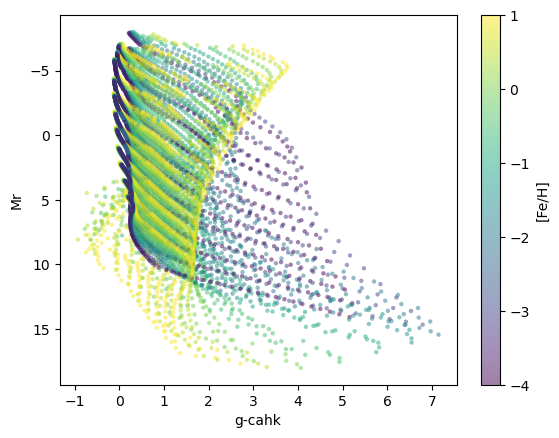

In [84]:
plt.scatter(cahksdss['cahk_AB']-cahksdss['sdss_g_AB'], cahksdss['sdss_r_AB'], 
            c=cahksdss['FeH'], s=10, lw=0, alpha=.5)
plt.colorbar().set_label('[Fe/H]')
plt.ylim(*plt.ylim()[::-1])
plt.xlabel('g-cahk')
plt.ylabel('Mr');

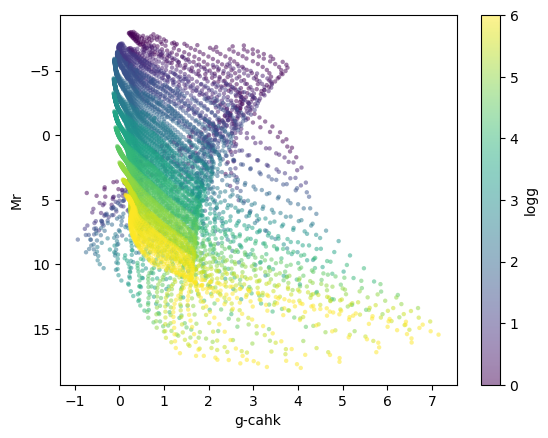

In [85]:
plt.scatter(cahksdss['cahk_AB']-cahksdss['sdss_g_AB'], cahksdss['sdss_r_AB'], 
            c=cahksdss['logg'], s=10, lw=0, alpha=.5)
plt.colorbar().set_label('logg')
plt.ylim(*plt.ylim()[::-1])
plt.xlabel('g-cahk')
plt.ylabel('Mr');

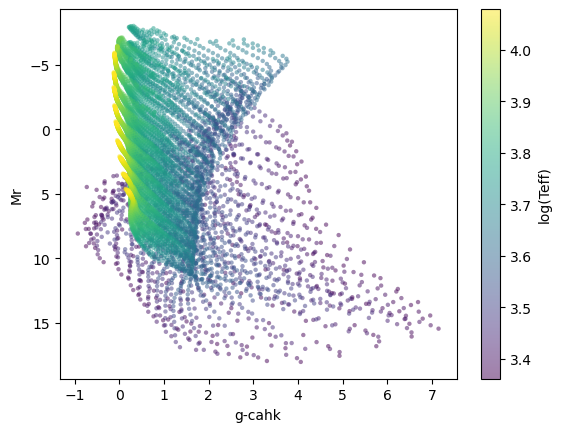

In [88]:
plt.scatter(cahksdss['cahk_AB']-cahksdss['sdss_g_AB'], cahksdss['sdss_r_AB'], 
            c=np.log10(cahksdss['Teff']), s=10, lw=0, alpha=.5)
plt.colorbar().set_label('log(Teff)')
plt.ylim(*plt.ylim()[::-1])
plt.xlabel('g-cahk')
plt.ylabel('Mr');

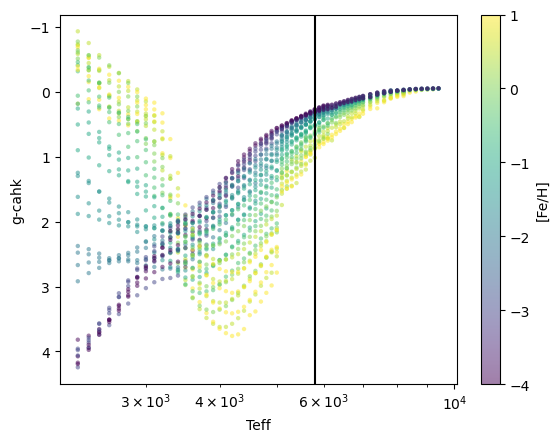

In [94]:
msk = cahksdss['logg'] < 2 #rgb

plt.scatter(cahksdss['Teff'][msk], cahksdss['cahk_AB'][msk]-cahksdss['sdss_g_AB'][msk], 
            c=cahksdss['FeH'][msk], s=10, lw=0, alpha=.5)
plt.semilogx()
plt.colorbar().set_label('[Fe/H]')
plt.ylim(*plt.ylim()[::-1])
plt.ylabel('g-cahk')
plt.xlabel('Teff')
plt.axvline(5800, c='k');

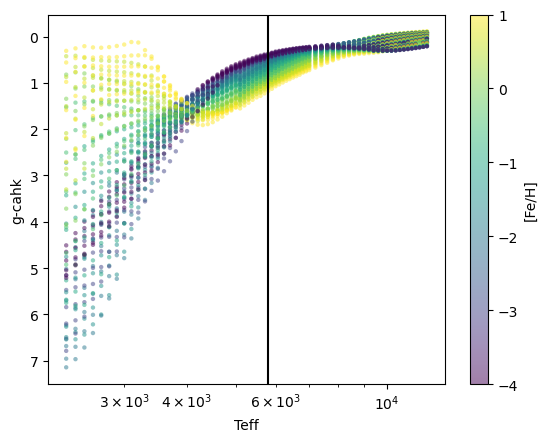

In [99]:
msk = cahksdss['logg'] > 3 # MS/PMS

plt.scatter(cahksdss['Teff'][msk], cahksdss['cahk_AB'][msk]-cahksdss['sdss_g_AB'][msk], 
            c=cahksdss['FeH'][msk], s=10, lw=0, alpha=.5)
plt.semilogx()
plt.colorbar().set_label('[Fe/H]')
plt.ylim(*plt.ylim()[::-1])
plt.ylabel('g-cahk')
plt.xlabel('Teff')
plt.axvline(5800, c='k');

Attempt to duplicate plot on https://sites.google.com/view/pristinesurvey/about-pristine

(0.2, -0.8)

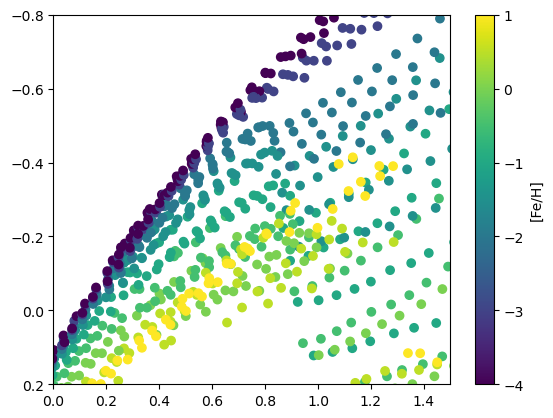

In [110]:
msk = cahksdss['logg'] < 2 # giants

x = cahksdss['sdss_g_AB'][msk] - cahksdss['sdss_i_AB'][msk]
y = cahksdss['cahk_AB'][msk] - cahksdss['sdss_g_AB'][msk] - 1.5*x
c = cahksdss['FeH'][msk]

plt.scatter(x, y, c=c)
plt.colorbar().set_label('[Fe/H]')

plt.xlim(0, 1.5)
plt.ylim(0.2, -.8)

(0.2, -0.8)

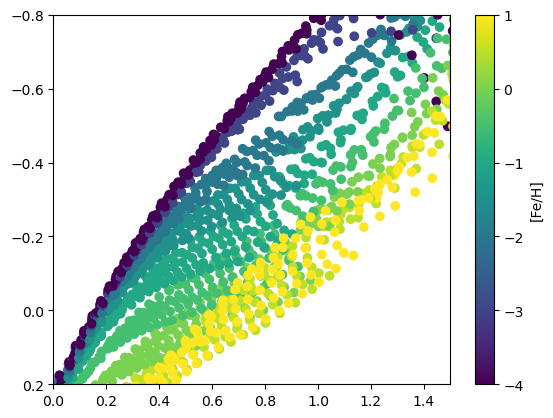

In [109]:
msk = cahksdss['logg'] > 3 # MS/PMS

x = cahksdss['sdss_g_AB'][msk] - cahksdss['sdss_i_AB'][msk]
y = cahksdss['cahk_AB'][msk] - cahksdss['sdss_g_AB'][msk] - 1.5*x
c = cahksdss['FeH'][msk]

plt.scatter(x, y, c=c)
plt.colorbar().set_label('[Fe/H]')

plt.xlim(0, 1.5)
plt.ylim(0.2, -.8)

In [ ]:
y